<a href="https://colab.research.google.com/github/yukisuzuki121210240311-lgtm/SougouEnshu-A/blob/master/ensyu_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# バイナリマスクを用いた音源分離


ここではバイナリマスクを用いた音源分離を実装しましょう．

---

必要なモジュールをインストール & インポートします．

In [1]:
!pip install japanize-matplotlib -U
!pip install pesq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=3eec17086dd95ab4f86203089ff21ce4efb28b58db52b6f8b42532dbd874411e
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib
  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp312-cp312-linux_x86_64.whl size=284119 sha256=76cca5d989b6fd6c6971def223b994221264f00176dbac64781b0ef4efe63bca
  Stored in directory: /root/.cache/pip/wheels/9b/d4/a4/9cf3512534cd47ce4a036d1593ee4013f2bf7509e631a147a3
Successfully built pesq


In [2]:
import numpy as np
import scipy.signal as sg       # 信号処理モジュール
import soundfile as sf          # wavファイルを扱う際のモジュール
from IPython.display import display, Audio  # iPython上でファイルを扱うためのモジュール
import urllib.request           # ファイルを読み込むためのモジュール
import matplotlib.pyplot as plt # 図を表示させるためのモジュール
import japanize_matplotlib      # 日本語を扱うためのモジュール
from pesq import pesq

## 0. 音声の読み込みと確認
音声ファイルの読み込みを行います．

```
音声ファイル群：
・ original_1.wav - 話者Aの音声
・ original_2.wav - 話者Bの音声
・ sound_2souces.wav - 話者Aと話者Bが同時に発話した収録音声
```

収録されたステレオ音声`sound_2souces.wav`に音源分離を行います．
左右のチャンネルの音声をそれぞれ x_l，x_r とします．

また，音声信号の各サンプルに対応する時刻[s]をもった配列として t を作成します．

In [20]:
# wavファイルをGoogle colabのワークスペースにもってくる
base_url = 'https://raw.githubusercontent.com/YosukeSugiura/SougouEnshu-A/master/' # Githubでrawデータを扱うためのurl
urllib.request.urlretrieve(base_url+'sound_2souces.wav', 'sound_2souces.wav') # マイクで収録したステレオ音声
urllib.request.urlretrieve(base_url+'original_1.wav', 'original_1.wav') # 音源A
urllib.request.urlretrieve(base_url+'original_2.wav', 'original_2.wav') # 音源B

# wavファイルの読み込み (sf.readの戻り値：データ，サンプリング周波数)
wav_data, fs = sf.read('sound_2souces.wav')  # マイクで収録したステレオ音声 (音源A+音源B)
original1, _ = sf.read('original_1.wav')  # 音源A
original2, _ = sf.read('original_2.wav')  # 音源B

# マイクで収録した音声に対して音源分離を行う．
x_l = wav_data[:,0]
x_r = wav_data[:,1]

# 各サンプルの時刻(波形の図示で使う)
t   = np.arange(len(x_l))/fs
t1 = np.arange(len(original1))/fs
t2 = np.arange(len(original2))/fs

音声波形を図で確認します．

Text(0, 0.5, 'Waveform (Right Ch.)')

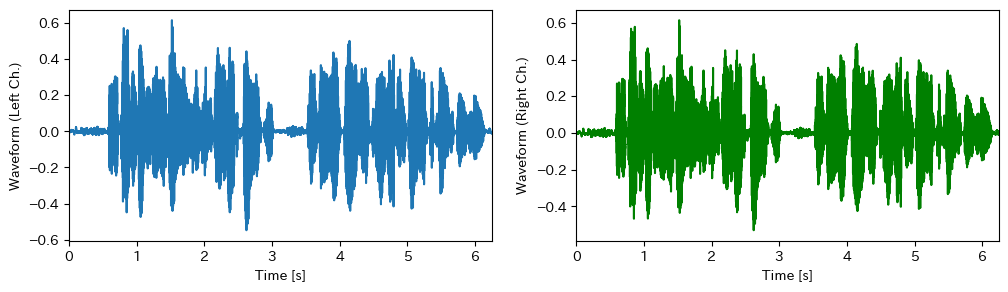

In [22]:
# 1 x 2 のグラフを２つ作成
fig1, ax1 = plt.subplots(1, 2, num=1, figsize=(12,3))

# 各グラフをプロット
ax1[0].plot(t, x_l)                     # 入力音声(左チャンネル)
ax1[1].plot(t, x_r, color='g')      # 入力音声(右チャンネル)

# x軸の範囲・ラベルの設定
for ax_ in ax1:
  ax_.set_xlim([t[0], t[-1]])
  ax_.set_xlabel("Time [s]")

# 軸のラベル・タイトルの設定
ax1[0].set_ylabel("Waveform (Left Ch.)")
ax1[1].set_ylabel("Waveform (Right Ch.)")


入力音声を聞くこともできます(イヤホン推奨)．
左右のチャンネルで，話者ごとの音量が(若干)異なります．

In [5]:
print('ステレオ音声')
display(Audio(wav_data.T, rate=fs))
print('左チャンネルの音声')
display(Audio(x_l, rate=fs))
print('右チャンネルの音声')
display(Audio(x_r, rate=fs))

ステレオ音声


左チャンネルの音声


右チャンネルの音声


## 1. 音声のSTFT

音声をフレームごとに分割して，短時間フーリエ変換(STFT)を行います．
関数`sg.stft`を用いれば，フレーム分割・窓関数・STFTもすべて一括で行ってくれます．
STFT後の周波数スペクトログラムは，左右チャンネルごとにそれぞれ X_l，X_r に保存します．

ここではフレーム長を1024サンプル，オーバーラップ長を512サンプルに設定しています．


In [6]:
# セグメント長，シフト長の指定
n_seg = 1024
n_overlap = round(1024*(1/2))

# 各チャンネルごとに短時間フーリエ変換
f, t, X_l = sg.stft(x_l, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 左チャンネル
_, _, X_r = sg.stft(x_r, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 右チャンネル

各チャンネルの音声のスペクトログラムを図で確認します．ここでは音声の特徴が見やすいように，0Hz～2kHzまでを表示しています．

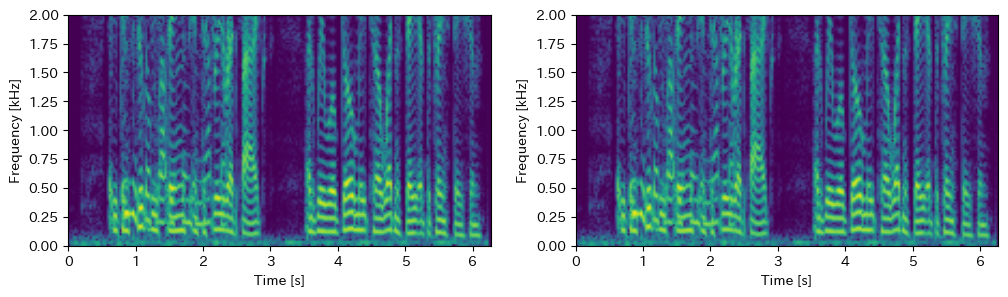

In [17]:
# パワースペクトログラムの計算
S_l = 10*np.log10(np.abs(X_l)**2+10**(-8))  # dB単位
S_r = 10*np.log10(np.abs(X_r)**2+10**(-8)) # dB単位

# 1 x 2 のグラフを作成
fig2, ax2 = plt.subplots(1, 2, num=1, figsize=(12,3))

# 各グラフをプロット
extent = [t.min(), t.max(), f.min()/1000, f.max()/1000] # 時間の範囲
ax2[0].imshow(S_l, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)
ax2[1].imshow(S_r, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)

# 軸名・範囲・タイトルの設定
for ax_ in ax2:
  ax_.set_ylim([0,2]) # 各グラフ，0~2kHzまでを表示
  ax_.set_ylabel("Frequency [kHz]")
  ax_.set_xlabel("Time [s]")


## 2. バイナリマスキング

スペクトログラムにバイナリマスクをかけてフィルタリングを行いましょう．
教科書をよく読み，バイナリマスクを実装しましょう．

(このサンプルコードは，入力音声をそのまま出力するフィルタリングを行っています．)

In [9]:
# マスクの作成

#↓↓ ここに音源分離を実現するマスクを作成しよう！
#     このサンプルコードでは，マスクのすべての値を1(=すべての周波数成分をそのまま通過させる)にしています．
#     自身で書き換えて，音源分離を実装しましょう．
#--------------------------------------

# ① バイナリマスクの作成（左右の強い方に1を付ける）
#  - X_l : 左マイクのSTFT（周波数 × 時間）
#  - X_r : 右マイクのSTFT（周波数 × 時間）

# パワー計算（絶対値2乗）
P_l = np.abs(X_l)**2
P_r = np.abs(X_r)**2

# 話者A（左側）のマスク：左のパワーが大きい部分を 1
G_a = (P_l >= P_r).astype(int)

# 話者B（右側）のマスク：右のパワーが大きい部分を 1
G_b = (P_r > P_l).astype(int)

#--------------------------------------
#↑↑ここまで

# スペクトログラムをマスキング
Y_a = G_a * X_l   # 話者Aの音だけ抽出
Y_b = G_b * X_r   # 話者Bの音だけ抽出


処理後の音声のスペクトログラムを確認しましょう．

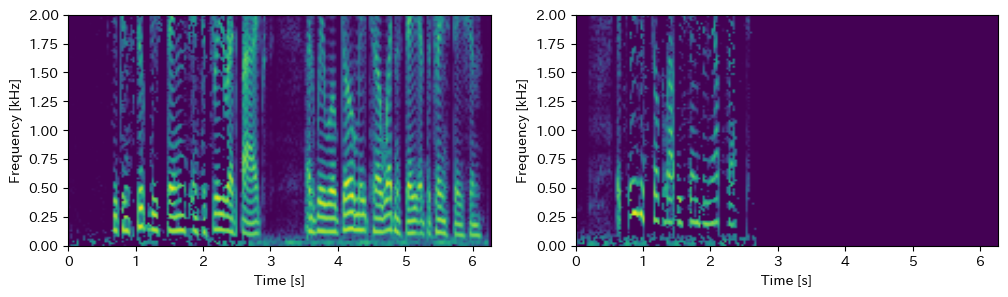

In [26]:
# パワースペクトログラムの計算
S_a = 10*np.log10(np.abs(Y_a)**2+10**(-8))  # dB単位
S_b = 10*np.log10(np.abs(Y_b)**2+10**(-8)) # dB単位

# 1 x 2 のグラフを作成
fig3, ax3 = plt.subplots(1, 2, num=1, figsize=(12,3))

# 各グラフをプロット
extent = [t.min(), t.max(), f.min()/1000, f.max()/1000] # 時間の範囲
ax3[0].imshow(S_a, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)
ax3[1].imshow(S_b, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)

# 軸名・範囲・タイトルの設定
for ax_ in ax3:
  ax_.set_ylim([0,2]) # 各グラフ，0~2kHzまでを表示
  ax_.set_ylabel("Frequency [kHz]")
  ax_.set_xlabel("Time [s]")


## 3. ISTFTによる音声波形の復元

処理音声に対して逆短時間フーリエ変換(Inverse Short Fourier Transform:ISTFT)を行い，音声波形を復元します．関数`sg.istft`を用いれば，オーバーラップアドも同時に行ってくれます．



In [24]:
# 各チャンネルごとに短時間フーリエ変換
t, y_a = sg.istft(Y_a, fs=fs, nperseg=n_seg, noverlap=n_overlap) # 戻り値：時刻，周波数スペクトル
_, y_b = sg.istft(Y_b, fs=fs, nperseg=n_seg, noverlap=n_overlap)

音声波形を確認します．

array([   0.   ,   15.625,   31.25 ,   46.875,   62.5  ,   78.125,
         93.75 ,  109.375,  125.   ,  140.625,  156.25 ,  171.875,
        187.5  ,  203.125,  218.75 ,  234.375,  250.   ,  265.625,
        281.25 ,  296.875,  312.5  ,  328.125,  343.75 ,  359.375,
        375.   ,  390.625,  406.25 ,  421.875,  437.5  ,  453.125,
        468.75 ,  484.375,  500.   ,  515.625,  531.25 ,  546.875,
        562.5  ,  578.125,  593.75 ,  609.375,  625.   ,  640.625,
        656.25 ,  671.875,  687.5  ,  703.125,  718.75 ,  734.375,
        750.   ,  765.625,  781.25 ,  796.875,  812.5  ,  828.125,
        843.75 ,  859.375,  875.   ,  890.625,  906.25 ,  921.875,
        937.5  ,  953.125,  968.75 ,  984.375, 1000.   , 1015.625,
       1031.25 , 1046.875, 1062.5  , 1078.125, 1093.75 , 1109.375,
       1125.   , 1140.625, 1156.25 , 1171.875, 1187.5  , 1203.125,
       1218.75 , 1234.375, 1250.   , 1265.625, 1281.25 , 1296.875,
       1312.5  , 1328.125, 1343.75 , 1359.375, 1375.   , 1390.

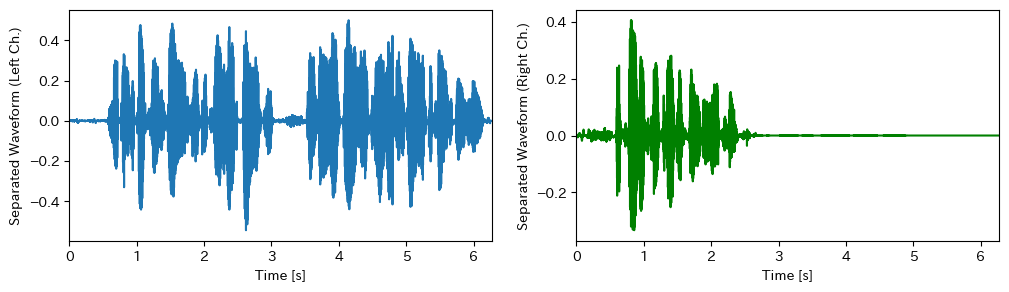

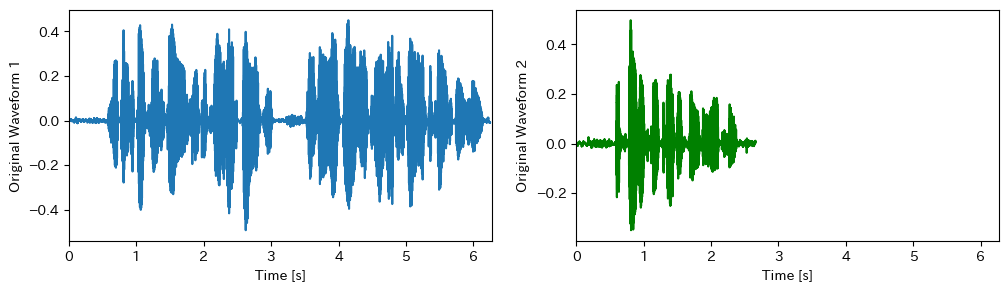

In [25]:
# 1 x 2 のグラフを２つ作成
fig4, ax4 = plt.subplots(1, 2, num=1, figsize=(12,3))
fig5, ax5 = plt.subplots(1, 2, num=2, figsize=(12,3))

# 各グラフをプロット
ax4[0].plot(t, y_a)                     # 音源A
ax4[1].plot(t, y_b, color='g')      # 音源B
ax5[0].plot(t1, original1)           # 処理後の左チャンネル
ax5[1].plot(t2, original2,color='g')# 処理後の左チャンネル

# x軸の範囲・ラベルの設定
for ax_ in np.r_[ax4,ax5]:
  ax_.set_xlim([t[0], t[-1]])
  ax_.set_xlabel("Time [s]")

# 軸のラベル・タイトルの設定
ax4[0].set_ylabel("Separated Waveform (Left Ch.)")
ax4[1].set_ylabel("Separated Waveform (Right Ch.)")
ax5[0].set_ylabel("Original Waveform 1")
ax5[1].set_ylabel("Original Waveform 2")
f

処理音声を聞いて音源が分離できていることを確認します．

In [13]:
print('処理音声 (音源A)')
display(Audio(y_a, rate = fs))
print('処理音声 (音源B)')
display(Audio(y_b, rate = fs))

処理音声 (音源A)


処理音声 (音源B)


## 4. 音質評価

PESQによる音質評価を行います．

> PESQ :   
> ITUが標準化した音声品質評価指標 [[link](https://www.itu.int/rec/T-REC-P.862/en)]．評価音声に対する参照音声の類似度を，人間の聴覚特性を考慮して数値化したもの．
> PESQは -0.5～4.5の値をとり，評価音声と参照音声が一致するときに4.5の値となる．大きいほど参照音声に近いことを示す．


In [27]:
score_l = pesq(fs, original1, y_a[:len(original1)])
score_r = pesq(fs, original2, y_b[:len(original2)])
print("原音声１に対する分離音声(左チャンネル)のPESQ評価値 = {0:.2f} ({1:.1f}%)".format(score_l, 100*(score_l+0.5)/5))
print("原音声２に対する分離音声(右チャンネル)のPESQ評価値 = {0:.2f} ({1:.1f}%)".format(score_r, 100*(score_r+0.5)/5))

原音声１に対する分離音声(左チャンネル)のPESQ評価値 = 3.34 (76.7%)
原音声２に対する分離音声(右チャンネル)のPESQ評価値 = 1.76 (45.3%)


以下のコードで処理音声のwavファイルをダウンロードできます．
ダウンロードしたい場合にはコメントアウトを外してください．



In [23]:
"""
sf.write('processed_sound2-2_l.wav', y_a, fs)
sf.write('processed_sound2-2_r.wav', y_b, fs)

from google.colab import files
files.download('processed_sound2-2_l.wav')
files.download('processed_sound2-2_r.wav')
"""

"\nsf.write('processed_sound2-2_l.wav', y_a, fs)\nsf.write('processed_sound2-2_r.wav', y_b, fs)\n\nfrom google.colab import files\nfiles.download('processed_sound2-2_l.wav')\nfiles.download('processed_sound2-2_r.wav')\n"